In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# import dateutil
from scipy import __version__ as scipy_version
import scipy.integrate
# import scipy.interpolate
# import scipy.stats
# from statsmodels import __version__ as statsmodels_version
# import statsmodels.formula.api as smformula

import io
from collections import OrderedDict
from IPython.display import display, HTML

print(sys.version)
print('numpy', np.__version__)
print('matplotlib', mpl.__version__)
print('pandas',pd.__version__)
print('scipy', scipy_version)
# print('statsmodels', statsmodels_version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
numpy 1.13.3
matplotlib 2.2.2
pandas 0.20.3
scipy 1.0.0


In [2]:
# Setup plot style
%matplotlib notebook
plt.style.use('seaborn-paper')
mpl.rcParams['figure.facecolor'] = (0.8, 0.8, 0.8, 1)

In [3]:
# APHIS 2011 Medfly model
DD_BASE_TEMP_MED = 12.3889 # in 'C; 12.3889'C = 54.3'F
DDc_PER_GEN_MED = 345.5556 # in DDc; 345.5556 DDc = 622 DDf

In [4]:
# Function which computes BM (single sine method) degree day generation from temperature data
def compute_BMDD(tmin, tmax, base_temp):
    # Used internally
    def _compute_daily_BM_DD(mint, maxt, avet, base_temp):
        """Use standard Baskerville-Ermin (single sine) degree-day method
        to compute the degree-day values for each a single day.
        """
        if avet is None:
            avet = (mint+maxt)/2.0 # simple midpoint (like in the refs)
        dd = np.nan # value which we're computing
        # Step 1: Adjust for observation time; not relevant
        # Step 2: GDD = 0 if max < base (curve all below base)
        if maxt < base_temp:
            dd = 0
        # Step 3: Calc mean temp for day; already done previously
        # Step 4: min > base; then whole curve counts
        elif mint >= base_temp:
            dd = avet - base_temp
        # Step 5: else use curve minus part below base
        else:
            W = (maxt-mint)/2.0
            tmp = (base_temp-avet) / W
            if tmp < -1:
                print('WARNING: (base_temp-avet)/W = {} : should be [-1:1]'.format(tmp))
                tmp = -1
            if tmp > 1:
                print('WARNING: (base_temp-avet)/W = {} : should be [-1:1]'.format(tmp))
                tmp = 1
            A = np.arcsin(tmp)
            dd = ((W*np.cos(A))-((base_temp-avet)*((np.pi/2.0)-A)))/np.pi
        return dd

    # compute the degree-days for each day in the temperature input (from tmin and tmax vectors)
    dd = pd.concat([tmin,tmax], axis=1)
    dd.columns = ['tmin', 'tmax']
    dd['DD'] = dd.apply(lambda x: _compute_daily_BM_DD(x[0], x[1], (x[0]+x[1])/2.0, base_temp), axis=1)
    return dd

In [44]:
data = pd.read_table('log2.log', skiprows=0, header=None, delim_whitespace=True,
                    names=['T','RH','ACOn','HeatOn','HumidOn','DehumidOn'])


<IPython.core.display.Javascript object>


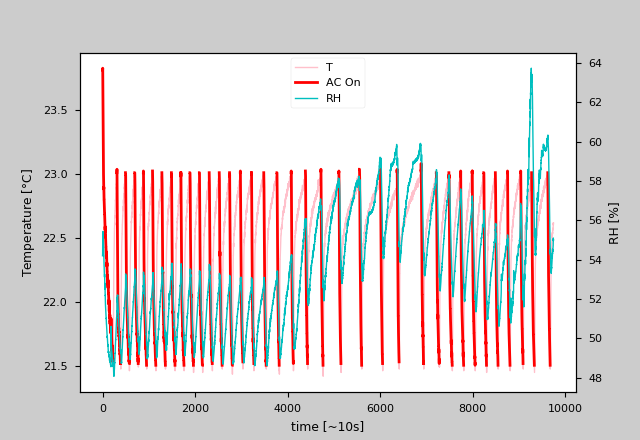

Text(0,0.5,'RH [%]')

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()

ax.plot(data.index, data['T'], ls='-', color='pink', label='T', lw=1)
ax2.plot(data.index, data['RH'], 'c-', label='RH', lw=1)

d = data.copy()
d.loc[~d['ACOn']] = np.nan
ax.plot(d.index, d['T'], 'r-', label='AC On', lw=2, zorder=6)

handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles+handles2, labels+labels2, loc='upper center')
ax.set_xlabel('time [~10s]')
ax.set_ylabel('Temperature [$\mathrm{\degree C}$]')
ax2.set_ylabel('RH [%]')

In [24]:
def read_chamber_log(fns, dd_base_temp=None, local_tz='US/Hawaii'):
    if isinstance(fns, str): fns = [fns]
    header = None
    buf = io.StringIO()
    for fn in fns:
        print(fn)
        with open(fn,'r') as fh:
            for l in fh:
                l = l.strip()
                if not l:
                    continue
                if header is None:
                    f = l.split('\t')
                    if f[2] == 'STAT_HEADER':
                        header = f[1:]
                        buf.write('\t'.join(f[2:]))
                        buf.write('\n')
                if l.startswith('STAT\t'):
                    buf.write(l)
                    buf.write('\n')
#     # debugging output
#     print(header)
#     buf.seek(0)
#     for i,l in enumerate(buf):
#         print(i,l, end='')
#         if i > 100: break
    # create a dataframe from the buffer
    buf.seek(0)
    df = pd.read_csv(buf, sep='\t')
    # set the index to proper time if given a tz
    if local_tz is not None:
        df.index = pd.to_datetime(df['time'],unit='s').dt.tz_localize('utc').dt.tz_convert(local_tz)
        df.sort_index(inplace=True)
    # compute simple summation DD if given a dd_base_temp
    if dd_base_temp is not None:
        tmp = df['T']-dd_base_temp
        tmp[tmp<0] = 0
        df['sumDD'] = scipy.integrate.cumtrapz(tmp,
                                    df.index.astype(int)*1e-9/(60*60*24),
                                    initial=0)
    return df

In [33]:
# df = read_chamber_log(('logs/chamberUSB0.log', 'logs/chamberUSB0_2018-06-29.log'), dd_base_temp=DD_BASE_TEMP_MED)
df = read_chamber_log('logs/chamberUSB3.log', dd_base_temp=DD_BASE_TEMP_MED)

df.head()

logs/chamberUSB3.log


,STAT_HEADER,time,ChamberAlarmStatus,T,TSetpoint,TAlarmStatus,H,HSetpoint,HAlarmStatus,HeatingPower,CoolingPower,HumidPower,DehumidPower,TimeSignal,sumDD
time,,,,,,,,,,,,,,,
2018-04-16 10:27:59.260000-10:00,STAT,1.523910e+09,0,16.0,16.0,0,80.3,80.0,0,0,65497,405,0,1,0.000000
2018-04-16 10:27:59.970000-10:00,STAT,1.523910e+09,0,16.2,16.0,0,79.7,80.0,0,0,65511,300,0,1,0.000030
2018-04-16 10:28:59.250000-10:00,STAT,1.523911e+09,0,16.0,16.0,0,79.4,80.0,0,24,0,427,0,1,0.002577
2018-04-16 10:29:59.260000-10:00,STAT,1.523911e+09,0,17.4,18.0,0,73.2,80.0,0,1209,0,1726,0,1,0.005571
2018-04-16 10:30:59.250000-10:00,STAT,1.523911e+09,0,17.7,18.0,0,75.5,80.0,0,1007,0,1408,0,1,0.009155


<IPython.core.display.Javascript object>


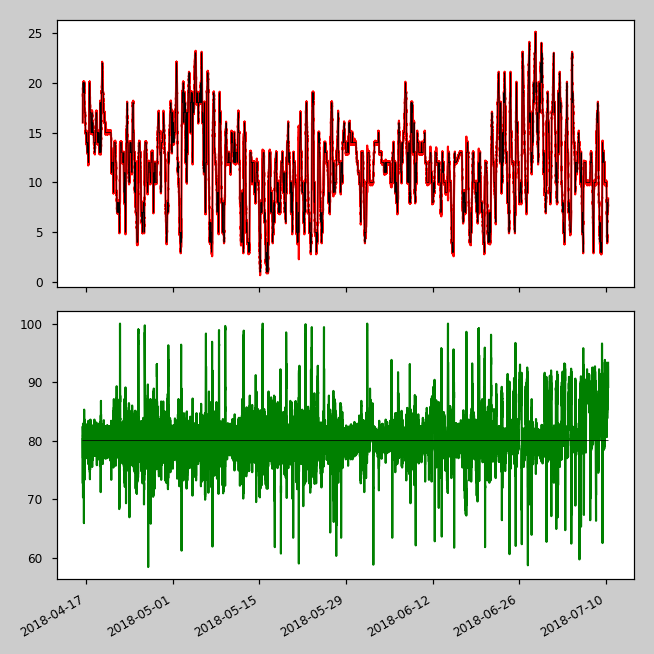

In [40]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2,1,1)
ax.plot(df.index, df['T'], c='r', ls='-', marker=None)
ax.plot(df.index, df['TSetpoint'], lw=.5, c='k', ls='-', marker=None)

ax2 = fig.add_subplot(2,1,2, sharex=ax)
ax2.plot(df.index, df['H'], c='g', ls='-', marker=None)
ax2.plot(df.index, df['HSetpoint'], lw=.5, c='k', ls='-', marker=None)

fig.autofmt_xdate()
fig.tight_layout()

<IPython.core.display.Javascript object>


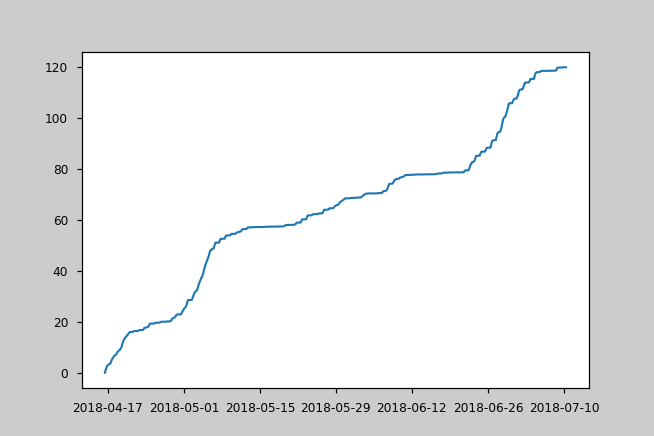

In [41]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(df.index, df['sumDD'], ls='-')

In [28]:
d0 = read_chamber_log('logs/chamberUSB0.log', dd_base_temp=DD_BASE_TEMP_MED)
d3 = read_chamber_log('logs/chamberUSB3.log', dd_base_temp=DD_BASE_TEMP_MED)
d4 = read_chamber_log('logs/chamber0.log', dd_base_temp=DD_BASE_TEMP_MED)

logs/chamberUSB0.log
logs/chamberUSB3.log
logs/chamber0.log


In [29]:
d0.head()

,STAT_HEADER,time,ChamberAlarmStatus,T,TSetpoint,TAlarmStatus,H,HSetpoint,HAlarmStatus,HeatingPower,CoolingPower,HumidPower,DehumidPower,TimeSignal,sumDD
time,,,,,,,,,,,,,,,
2018-06-29 08:29:18.520000-10:00,STAT,1.530297e+09,0,25.3,24.2,0,75.0,91.3,0,0,64718,9154,0,1,0.000000
2018-06-29 08:29:19.240000-10:00,STAT,1.530297e+09,0,25.3,24.2,0,74.5,91.3,0,0,64854,8835,0,1,0.000108
2018-06-29 08:30:18.520000-10:00,STAT,1.530297e+09,0,24.4,24.2,0,92.1,91.3,0,41,0,302,0,1,0.008657
2018-06-29 08:31:18.520000-10:00,STAT,1.530297e+09,0,24.5,24.2,0,93.7,91.3,0,0,65472,761,0,1,0.017033
2018-06-29 08:32:18.520000-10:00,STAT,1.530297e+09,0,24.4,24.2,0,91.3,91.3,0,19,65472,2176,0,1,0.025409


<IPython.core.display.Javascript object>


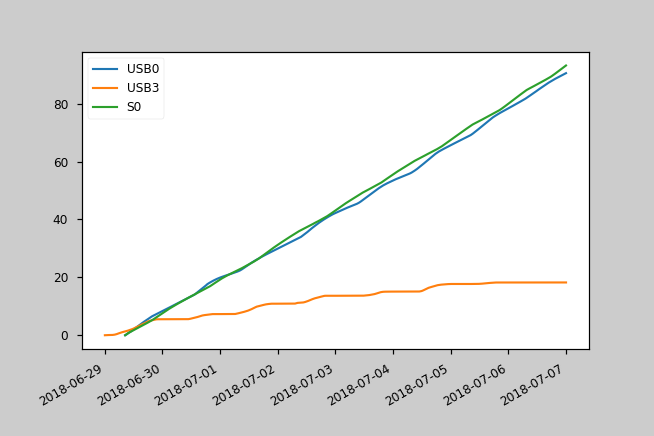

In [30]:
r1 = '2018-06-29'
r2 = '2018-07-06'

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

for lab,d in (('USB0',d0),
              ('USB3',d3),
              ('S0',d4)
             ):
    t = d.loc[r1:r2]
#     t = d
    ax.plot(t.index, t['sumDD']-t['sumDD'].iloc[0], ls='-', label=lab)
    
ax.legend()
fig.autofmt_xdate()